To run this notebook pyrocko needs to be installed (https://pyrocko.org/docs/current/install/) and matplotlib. matplotlib basemap is recommended. 

In [72]:
from collections import defaultdict

import numpy as num
from matplotlib import pyplot as plt

from pyrocko.guts import Float

from pyrocko import gf, trace, plot, beachball, util, model, orthodrome
from pyrocko import moment_tensor as pmt

km = 1000.

util.setup_logging('shakemap')



def make_scenario(engine, source, stations=None, grid_extent=50, ngrid=50, store_id="insheim_100hz_small"):
    '''
    Setup scenario with source model, STF and a rectangular grid of targets.
    '''

    # physical grid size in [m]
    grid_extent = grid_extent*km

    # number of grid points
    nnorth = neast = ngrid

    if stations is None:

        # receiver grid
        r = grid_extent / 2.0

        norths = num.linspace(-r, r, nnorth)
        easts = num.linspace(-r, r, neast)

        store = engine.get_store(store_id)

        norths2, easts2 = coords_2d(norths, easts)

        targets = []
        for i in range(norths2.size):

            for component in 'ZNE':
                target = gf.Target(
                    quantity='displacement',
                    codes=('', '%04i' % i, '', component),
                    lat=source.lat,
                    lon=source.lon,
                    north_shift=float(norths2[i]),
                    east_shift=float(easts2[i]),
                    store_id=store_id,
                    interpolation='nearest_neighbor')

                # in case we have not calculated GFs for zero distance
                if source.distance_to(target) >= store.config.distance_min:
                    targets.append(target)
    else:
        store = engine.get_store(store_id)
        targets = []
        norths = []
        easts = []
        # here maybe use common ne frame?
        for i, st in enumerate(stations):
            north, east = orthodrome.latlon_to_ne_numpy(
                source.lat,
                source.lon,
                st.lat,
                st.lon,
                )
            norths.append(north[0])
            easts.append(east[0])
            norths2, easts2 = coords_2d(north, east)

            for cha in st.channels:
                target = gf.Target(
                    quantity='displacement',
                    codes=(str(st.network), i, str(st.location),
                           str(cha.name)),
                    lat=source.lat,
                    lon=source.lon,
                    north_shift=float(norths2),
                    east_shift=float(easts2),
                    store_id=store_id,
                    interpolation='nearest_neighbor')
                # in case we have not calculated GFs for zero distance
                if source.distance_to(target) >= store.config.distance_min:
                    targets.append(target)
        norths = num.asarray(norths)
        easts = num.asarray(easts)

    return source, targets, store_id, norths, easts, stf_spec



def post_process(response, norths, easts, stf_spec, stations=False,
                 show=True, savedir=None, save=False, quantity="velocity"):
    nnorth = norths.size
    neast = easts.size

    norths2, easts2 = coords_2d(norths, easts)

    by_i = defaultdict(list)
    traces = []
    for source, target, tr in response.iter_results():
        tr = tr.copy()

        if quantity == "velocity":
            trans = trace.DifferentiationResponse(1)
        if quantity == "acceleration":
            trans = trace.DifferentiationResponse(2)

        if quantity is not "displacement":
            trans = trace.MultiplyResponse(
                [trans, stf_spec])

            tr = tr.transfer(transfer_function=trans)
        # uncomment for filtering
        #tr.highpass(4, 0.5)
        #tr.lowpass(4, 4.0)
        tr_resamp = tr.copy()

        # uncomment to active resampling to get a smooth image (slow):
        tr_resamp.resample(tr.deltat*0.25)
        by_i[int(target.codes[1])].append(tr_resamp)
        traces.append(tr)
    values = num.zeros(nnorth*neast)
# Uncomment if you want to save the seismograms
#    from pyrocko import trace as trd
#    if stations is True:

#        trd.snuffle(traces)
#    if stations is True:
#        from pyrocko import io
#        io.save(traces, "traces_pgv.mseed")
    plot_trs = []
    for i in range(norths2.size):
        trs = by_i[i]
        if trs:
            ysum = num.sqrt(sum(tr.ydata**2 for tr in trs))
            ymax = num.max(ysum)
            values[i] = ymax
            if norths2[i] == easts2[i]:
                plot_trs.extend(trs)
    values = values.reshape((norths.size, easts.size))
    if save is True:
        path = savedir + '/shakemap.pkl'
        f = open(path, 'wb')
        pickle.dump([values, easts, norths], f)
        f.close()

    return values


def coords_2d(norths, easts):
    norths2 = num.repeat(norths, easts.size)
    easts2 = num.tile(easts, norths.size)
    return norths2, easts2


class BruneResponse(trace.FrequencyResponse):

    duration = Float.T()

    def evaluate(self, freqs):
        return 1.0 / (1.0 + (freqs*self.duration)**2)



Simple plotting function of the resulting synthetic shakemap:

In [73]:
def plot_shakemap(source, norths, easts, values, filename):
    plot.mpl_init()
    fig = plt.figure(figsize=plot.mpl_papersize('a5', 'landscape'))
    axes = fig.add_subplot(1, 1, 1, aspect=1.0)

    axes.set_xlim(easts.min()/km, easts.max()/km)
    axes.set_ylim(norths.min()/km, norths.max()/km)

    axes.set_xlabel('Easting [km]')
    axes.set_ylabel('Northing [km]')

    _, vmax = num.min(values), num.max(values)

    im = axes.contourf(
        easts/km, norths/km, values,
        vmin=0., vmax=vmax,
        cmap=plt.get_cmap('YlOrBr'))

    fig.colorbar(im, label='Acceleration [m/s^2]')

    mt = source.pyrocko_moment_tensor()

    beachball.plot_beachball_mpl(
        mt, axes,
        position=(0., 0.),
        color_t='black',
        zorder=2,
        size=20.)

    fig.savefig(filename)
    plt.show()


Call all the functions. A pre-calcuated greens function store is needed

--- !pf.DCSource
lat: 49.15
lon: 8.147
depth: 6000.0
time: 2019-04-01 13:13:13
stf_mode: post
magnitude: 1.1907621315742212
strike: 111.0
dip: 85.0
rake: 5.0

--- !pf.ProcessingStats
t_perc_get_store_and_receiver: 20.0
t_perc_discretize_source: 20.0
t_perc_make_base_seismogram: 20.0
t_perc_make_same_span: 20.0
t_perc_post_process: 20.0
t_perc_optimize: 0.0
t_perc_stack: 0.0
t_perc_static_get_store: 0.0
t_perc_static_discretize_basesource: 0.0
t_perc_static_sum_statics: 0.0
t_perc_static_post_process: 0.0
t_wallclock: 1.0339713096618652
t_cpu: 1.0333329999999705
n_read_blocks: 0
n_results: 0
n_subrequests: 0
n_stores: 0
n_records_stacked: 7500

Maximum PGA: 1.09396e-05 m/s^2


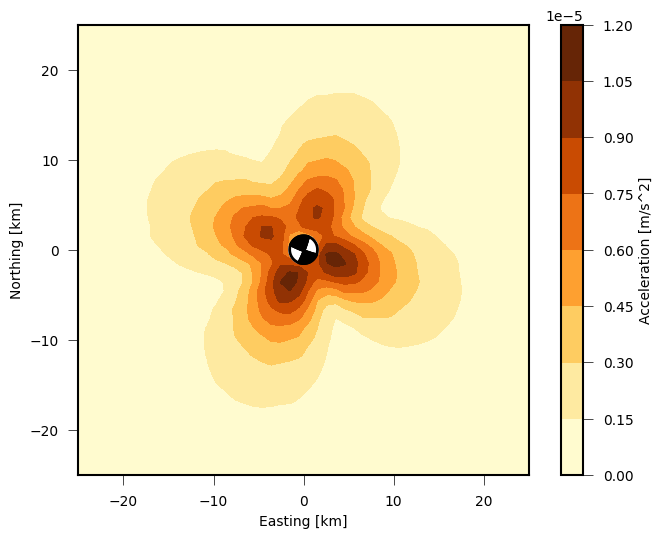

In [74]:
# location where gf stores are located
gf_store_superdirs = "gf_stores"
# Green's functions to use, can be exchanged to any qseis/qssp calculated store
store_id = 'insheim_100hz_small'

engine = gf.LocalEngine(store_superdirs=[gf_store_superdirs])

# source time function (STF) based on Brune source model, to get
# spectra roughly realistic
radius = 0.1*km
stress_drop = 3.0e4
magnitude = float(pmt.moment_to_magnitude(
    16./7. * stress_drop * radius**3))
rupture_velocity = 0.9 * 3000.
duration = 1.5 * radius / rupture_velocity
stf_spec = BruneResponse(duration=duration)

# source model without STF, will convolve afterwards, manually
# soure properties can be changed here

lat=49.15
lon=8.147
source = gf.DCSource(
    time=util.str_to_time('2019-04-01 13:13:13'),
    lat=lat,
    lon=lon,
    depth=6.*km,
    magnitude=magnitude,
    strike=111.,
    dip=85.,
    rake=5.)
    
# scenario setup is hard-coded in the make_scenario() function in this notebook, please change it there
source, targets, store_id, norths, easts, stf_spec = make_scenario(engine, source)

# reminder how the source looks like
print(source)

# model raw displacement seismograms
response = engine.process(source, targets)

# show some computational infos
print(response.stats)

# convolve displacement seismograms with STF and convert to acceleration
values = post_process(response, norths, easts, stf_spec)

print('Maximum PGA: %g m/s^2' % num.max(values))

plot_shakemap(source, norths, easts, values, 'gf_shakemap.pdf')

Get the pga/pgv values for stations from a list of stations in a pyrocko format station list and apply correction factors from Eulenfeld et al.

In [68]:
stations = model.load_stations("stations.pf")
source, targets_stations, store_id, norths_stations, easts_stations, stf_spec = make_scenario(engine, source, stations=stations)


response_stations = engine.process(source, targets_stations)

values_stations = post_process(response_stations, norths_stations,
                               easts_stations,
                               stf_spec, stations=True)

values_stations = values_stations[0][0:len(stations)]

stations_corrections_file = num.genfromtxt("station_factors.txt",
                                        delimiter=",", dtype=None)
for i_st, st in enumerate(stations):
    for stc in stations_corrections_file:
        if st.station == stc[0].decode():
            stations_corrections_value.append(float(stc[1]))
            values_stations[i_st] = values_stations[i_st] + (values_stations[i_st]*float(stc[1]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


Advanced plotting of the shakemap with station values on a DEM (matplotlib basemap needed, sudo apt-get install libgeos-dev
sudo pip3 install -U git+https://github.com/matplotlib/basemap.git).


Correction with vs30 values from topography slope derived values possible for each gridpoint with input from the vs30 module from the silvertine framework (not shown here).
Automatically draws fuzzy beachball if n sources are given. 
Also allows to consider ensembles of shakemaps from n-mechanisms, therefore all inputs are considered lists.
value_level draws contours for a given threshold from the ensemble of shakemaps. 

In [75]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

def plot_shakemap_detailed(sources, norths, easts, values_list, filename, folder,
                  stations,
                  values_stations_list=None, easts_stations=None,
                  norths_stations=None, latlon=True, show=False,
                  plot_background_map=True, measured=None,
                  value_level=0.001, quantity="velocity",
                  scale="mm", plot_values=False, vs30=False,
                  engine=None, type_factors=None, store_id=None):
    plot.mpl_init()
    fig = plt.figure(figsize=plot.mpl_papersize('a5', 'landscape'))
    axes = fig.add_subplot(1, 1, 1, aspect=1.0)
    mts = []
    plot_kwargs = {
        'size': 4000,
        'edgecolor': 'black'
        }

    for i, source in enumerate(sources):
        mts.append(source.pyrocko_moment_tensor())
        if i == 0:
            best_mt = source.pyrocko_moment_tensor()
    for i, values_pertubed in enumerate(values_list):
        if i == 0:
            values = values_pertubed
            values_cum = num.zeros(num.shape(values))
            values_cum = values_cum + values
        else:
            values_cum = values_cum + values_pertubed
    vales_cum = values_cum/float(len(values_list))
    if scale == "mm":
        values = values*1000.
    if values_stations_list is not None:
        values_stations = values_stations_list[0]
        if scale == "mm":
            values_stations = values_stations*1000.

    if latlon is False:
        axes.set_xlim(easts.min()/km, easts.max()/km)
        axes.set_ylim(norths.min()/km, norths.max()/km)

        axes.set_xlabel('Easting [km]')
        axes.set_ylabel('Northing [km]')

        im = axes.contourf(
            easts/km, norths/km, values,
            vmin=0., vmax=vmax,
            cmap=plt.get_cmap('YlOrBr'))

        if quantity == "velocity":
            if scale == "mm":
                fig.colorbar(im, label='Velocity [mm/s]')
            else:
                fig.colorbar(im, label='Velocity [m/s]')
        if quantity == "acceleration":
            if scale == "mm":
                fig.colorbar(im, label='Velocity [mm/s]')
            else:
                fig.colorbar(im, label='Velocity [m/s]')

        if source.base_key()[6] is not "ExplosionSource":
            beachball.plot_fuzzy_beachball_mpl_pixmap(
                mts, axes, best_mt,
                position=(0, 0.),
                color_t='black',
                **plot_kwargs)
        if values_stations is not None:
            plt.scatter(easts_stations/km, norths_stations/km,
                        c=values_stations, s=36, cmap=plt.get_cmap('YlOrBr'),
                        vmin=0., vmax=vmax, edgecolor="k")
    else:
        lats = []
        lons = []
        for east, north in zip(easts, norths):
            lat, lon = orthodrome.ne_to_latlon(source.lat, source.lon,
                                               north, east)
            lats.append(lat)
            lons.append(lon)

        if vs30 is True:
            from silvertine.shakemap import vs30
            values_vs30 = vs30.extract_rectangle(num.min(lons), num.max(lons), num.min(lats), num.max(lats))
            from scipy import ndimage
            factor_x = num.shape(values)[0]/num.shape(values_vs30)[0]
            factor_y = num.shape(values)[1]/num.shape(values_vs30)[1]
            values_vs30_resam = ndimage.zoom(values_vs30, (factor_x, factor_y))

            store = engine.get_store(store_id)
            if type_factors is None:
                layer0 = store.config.earthmodel_1d.layer(0)
                base_velocity = layer0.mtop.vs
                base_velocity = 400.
                type_factors = 1
                amp_factor = (base_velocity/values_vs30_resam)**type_factors
                values = values*amp_factor

        if plot_background_map is True:
            map = Basemap(projection='merc',
                          llcrnrlon=num.min(lons),
                          llcrnrlat=num.min(lats),
                          urcrnrlon=num.max(lons),
                          urcrnrlat=num.max(lats),
                          resolution='h', epsg=3395)
            ratio_lat = num.max(lats)/num.min(lats)
            ratio_lon = num.max(lons)/num.min(lons)

            map.drawmapscale(num.min(lons)+0.05,
                             num.min(lats)+0.05,
                             num.min(lons), num.min(lats), 10)
            parallels = num.arange(num.around(num.min(lats), decimals=2),
                                   num.around(num.max(lats), decimals=2), 0.1)
            meridians = num.arange(num.around(num.min(lons), decimals=2),
                                   num.around(num.max(lons), decimals=2), 0.2)
            map.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=22)
            map.drawmeridians(meridians, labels=[1, 1, 0, 1], fontsize=22)
            xpixels = 1000
            try:
                map.arcgisimage(service='World_Shaded_Relief', xpixels=xpixels,
                                verbose=False, zorder=1, cmap="gray")
            except urllib.error.URLError:
                pass

        if plot_background_map is True:
            pos1, pos2 = map(source.lon, source.lat)
        else:
            pos1 = source.lat
            pos2 = source.lon
        if source.base_key()[6] is not "ExplosionSource":
            beachball.plot_fuzzy_beachball_mpl_pixmap(
                mts, axes, best_mt,
                position=(pos1, pos2),
                color_t='black',
                zorder=2,
                **plot_kwargs)

        if plot_background_map is True:
            lats_map, lons_map = map(lons, lats)
            values[values == 0] = 'nan'
            alpha = 0.5
        else:
            lats_map, lons_map = lats, lons
            alpha = 1.
        _, vmax = num.min(values), num.max(values)

        if values_stations_list is not None:
            st_lats, st_lons = [], []
            for st in stations:
                st_lats.append(st.lat)
                st_lons.append(st.lon)
            if plot_background_map is True:
                st_lats, st_lons = map(st_lons, st_lats)
            if plot_values is True and measured is not None:
                measured_values = []
            try:
                for k, st in enumerate(stations):
                    for data in measured:
                            if data[0].decode() == st.station:
                                if scale == "mm":
                                    measured_values.append(data[1]*1000.)
                _, vmax = num.min(measured_values), num.max(measured_values)

            except:
                measured_values = []
                if measured is not None:
                    for data in measured:
                        if scale == "mm":
                            measured_values.append(data*1000.)

                    _, vmax = num.min(measured_values), num.max(measured_values)

            if plot_values is True and measured is None:
                plt.scatter(st_lats, st_lons,
                            c=num.asarray(values_stations), s=36,
                            cmap=plt.get_cmap('YlOrBr'),
                            vmin=0., vmax=vmax, edgecolor="k", alpha=alpha)
                for k, st in enumerate(stations):
                    plt.text(st_lats[k], st_lons[k], str(st.station))
            if plot_values is True and measured is not None:
                plt.scatter(st_lats, st_lons,
                            c=num.asarray(measured_values), s=36,
                            cmap=plt.get_cmap('YlOrBr'),
                            vmin=0., vmax=vmax, edgecolor="k", alpha=alpha)
                for k, st in enumerate(stations):
                    plt.text(st_lats[k], st_lons[k], str(st.station))
            if measured is not None and plot_values is False:
                residuals = []
                stations_write = []
                try:
                    for k, st in enumerate(stations):
                        for data in measured:
                            # case for manual input
                            if data[0].decode() == st.station:
                                residuals.append(values_stations[k]-data[1])
                                stations_write.append(st.station)
                except:
                    if measured is not None:
                        for data in measured:
                            # case for measured input
                            residuals.append(values_stations[k]-data)
                            stations_write.append(st.station)
                fobj = open(os.path.join(folder, 'residuals.txt'), 'w')
                for i in range(0, len(residuals)):
                    fobj.write('%s %.20f\n' % (stations_write[i],
                                               residuals[i]))
                fobj.close()

                fobj = open(os.path.join(folder, 'synthetic_pga.txt'), 'w')
                for i in range(0, len(residuals)):
                    fobj.write('%s %.20f\n' % (stations_write[i],
                                               values_stations[i]))
                fobj.close()

                plt.scatter(st_lats, st_lons,
                            c=residuals, s=36, cmap=plt.get_cmap('YlOrBr'),
                            vmin=0., vmax=vmax, edgecolor="k", alpha=alpha)
        im = axes.contourf(
            lats_map, lons_map, values.T,
            vmin=0., vmax=vmax,
            cmap=plt.get_cmap('YlOrBr'),
            alpha=alpha)
        if quantity == "velocity":
            if scale == "mm":
                #fig.colorbar(im, label='Velocity [mm/s]')
                m = plt.cm.ScalarMappable(cmap=plt.get_cmap('YlOrBr'))
                m.set_array(values)
                m.set_clim(0., vmax)
                plt.colorbar(m, boundaries=num.linspace(0, vmax, 6))
            else:
                fig.colorbar(im, label='Velocity [m/s]')
        if quantity == "acceleration":
            if scale == "mm":
                fig.colorbar(im, label='Velocity [mm/s]')
            else:
                fig.colorbar(im, label='Velocity [m/s]')


        axes.contour(lats_map, lons_map, vales_cum.T, cmap='brg',
                     levels=[value_level])

    fig.savefig(folder+filename)
    if show is True:
        plt.show()
    else:
        plt.close()
    if vs30 is not False:
        fig = plt.figure(figsize=plot.mpl_papersize('a5', 'landscape'))
        axes = fig.add_subplot(1, 1, 1, aspect=1.0)

        map = Basemap(projection='merc',
                      llcrnrlon=num.min(lons),
                      llcrnrlat=num.min(lats),
                      urcrnrlon=num.max(lons),
                      urcrnrlat=num.max(lats),
                      resolution='h', epsg=3395)
        ratio_lat = num.max(lats)/num.min(lats)
        ratio_lon = num.max(lons)/num.min(lons)

        parallels = num.arange(num.around(num.min(lats), decimals=2),
                               num.around(num.max(lats), decimals=2), 0.1)
        meridians = num.arange(num.around(num.min(lons), decimals=2),
                               num.around(num.max(lons), decimals=2), 0.2)
        map.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=22)
        map.drawmeridians(meridians, labels=[1, 1, 0, 1], fontsize=22)
        im = map.imshow(num.rot90(values_vs30.T))
        fig.colorbar(im, label='Velocity [m/s]')
        fig.savefig(folder+"vs30.png")
        plt.show()
        


Call the full plot with the values for each grid point and for the stations. Saves the figures into the defined folder. 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:240: UserWarning: No contour levels were found within the data range.


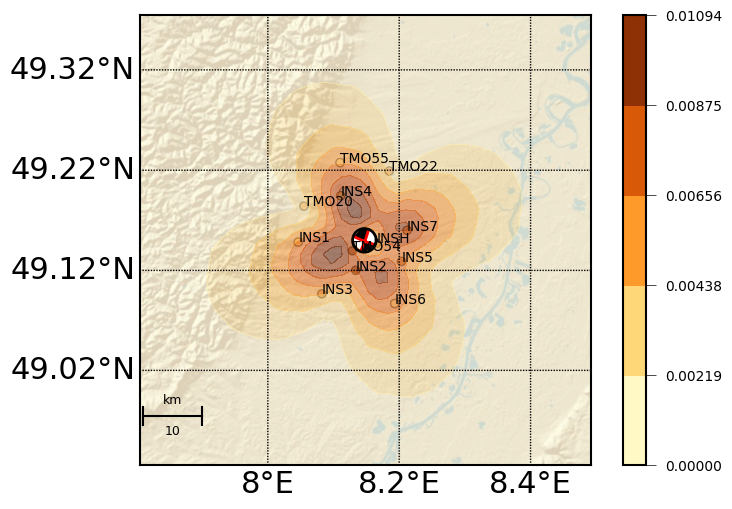

In [76]:
plot_shakemap_detailed([source], norths, easts, [values],
              'gf_shakemap.png', ".",
              stations, value_level=0.001, engine=engine,
              values_stations_list=[values_stations],
              norths_stations=norths_stations,
              easts_stations=easts_stations,
              plot_values=True,
              store_id=store_id, show=True)